Este Notebook contém minhas anotações, e é baseado no original disponível em: https://www.kaggle.com/phelpsmemo/cap-351-neurocomputacao-projeto1-mlp

# Projeto 1 - Experimentos com a rede MultiLayer Perceptron (MLP)

**Descrição do projeto**: No projeto 1 deve ser desenvolvido experimentos com a rede MLP, variando seus parâmetros para o entendimento inicial do impacto que os parâmetros tem no processo de aprendizado da rede. Abaixo, os requisitos específicados são apresentados

- Realizar testes com um dataset selecionado usando várias configuração da rede

- Ilustrar graficamente o processo de aprendizagem pela redução do erro quadrático médio

- Dividir o conjunto em duas partes (Treino e Validação) 

- Entregar um relatório descrevendo os experimentos

**Considerar**: Impacto do termo de momentum e do impacto da regularização L2. Usar o algoritmo de retropropagação original (SGD)

In [1]:
import tensorflow
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import random as python_random

# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
random_seed = 777
python_random.seed(random_seed)
np.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)

### Funções auxiliares

Nesta seção são adicionadas algumas funcionalidades para auxiliar o processo de desenvolvimento dos experimentos e seus testes.


In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec


# def plot_model_fit(
#        fit_history: tensorflow.python.keras.callbacks.History) -> None:
def plot_model_fit(fit_history) -> None:
    """Função para visualizar a variação da acurácia de treino e teste do modelo ajustado

    Args:
        fit_history (tensorflow.python.keras.callbacks.History): Histórico do ajuste do modelo
    Returns:
        None
    """
    plt.figure(dpi=120)

    gs = gridspec.GridSpec(2, 1)
    sp0 = plt.subplot(gs[0])

    sp0.plot(fit_history.epoch, fit_history.history["accuracy"])
    sp0.plot(fit_history.epoch, fit_history.history["val_accuracy"])
    sp0.set_title("Variação da acurácia durante o treino")
    sp0.legend(["Acurácia", "Acurácia (Validação)"])

    sp1 = plt.subplot(gs[1])
    sp1.plot(fit_history.epoch, fit_history.history["loss"])
    sp1.plot(fit_history.epoch, fit_history.history["val_loss"])
    sp1.set_title("Variação da função custo")
    sp1.legend(["Função custo", "Função custo (Validação)"])

    sp0.grid(True)
    sp1.grid(True)
    plt.tight_layout()
    plt.show()


def plot_multiple_history(histories: list, nneurons: list) -> None:
    """Visualização de múltiplos históricos, considerando a variação na quantidade
    de neurônios de camada modelo gerado.
    """
    plt.figure(dpi=100)

    for history, testn in zip(histories, range(len(histories))):
        plt.plot(
            history.epoch,
            history.history["val_accuracy"],
            label=f"Teste {testn + 1} (Neurônios = {nneurons[testn]})",
        )

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_history_curves_by_label(
    fit_histories: list,
    test_label_pattern: str,
    fnc_label: "lambda function",
) -> None:
    """Função para visualizar a variação da acurácia de treino e teste do modelo ajustado

    Args:
        fit_history (tensorflow.python.keras.callbacks.History): Histórico do ajuste do modelo
    Returns:
        None
    """
    plt.figure(dpi=135)

    gs = gridspec.GridSpec(2, 1)
    sp0 = plt.subplot(gs[0])
    sp1 = plt.subplot(gs[1])

    for i in range(len(fit_histories)):
        label = f"{test_label_pattern.format(idx = fnc_label(i))}"

        fit_history = fit_histories[i][0]  # [0] = history
        sp0.plot(
            fit_history.epoch,
            fit_history.history["val_accuracy"],
            label=f"{i + 1} ({label})",
        )
        sp1.plot(
            fit_history.epoch,
            fit_history.history["val_loss"],
            label=f"{i + 1}",
        )

    sp0.legend(
        title="Acurácia (Validação)",
        fancybox=True,
        shadow=True,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
    )
    sp1.legend(
        title="Custo (Validação)",
        fancybox=True,
        shadow=True,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
    )

    sp0.grid(True)
    sp1.grid(True)
    plt.tight_layout()
    plt.show()

## Experimento 1

Este primeiro experimento tem como objetivo a aplicação e verificação do impacto causado pela variação dos hiperparâmetros da rede MLP.

### Conjunto de dados

Para o desenvolvimento deste projeto será feita a utilização do conjunto de dados [Wine](http://archive.ics.uci.edu/ml/datasets/Wine/) disponibilizado no [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php). O acesso aos dados é feito através da biblioteca [scikit-learn](https://scikit-learn.org/stable/).

No total, o conjunto de dados possui 13 atributos, os quais descrevem as propriedades físico-quimicas de 3 tipos de vinhos diferentes. Os atributos são listados abaixo

- `Alcohol`
- `Malic acid`
- `Ash`
- `Alcalinity of ash`
- `Magnesium`
- `Total phenols`
- `Flavanoids`
- `Nonflavanoid phenols`
- `Proanthocyanins`
- `Color intensity`
- `Hue`
- `OD280/OD315 of diluted wines`
- `Proline`

Este conjunto de dados será utilizado no contexto da atividade de `Classificação`, desenvolvida com o uso das redes MLP. Assim, os 13 atributos serão utilizados para aproximar as propriedades com o tipo de vinho, possibilitando que classificações sejam realizadas.

In [3]:
import pandas as pd
from sklearn.datasets import load_wine

**Formatação e tratamento nos dados**

In [4]:
# carregando os dados
winedata = load_wine(as_frame=True)

winedata.data.head(n=3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0


Para realizar o treinamento e validação do aprendizado da rede MLP, faz-se necessário a criação a divisão do conjunto de dados em dois grupos, **Treino** (70%) e **Teste** (30%). Esta operação é feita abaixo com o auxílio da biblioteca `scikit-learn`.

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_trainnu, y_testnu = train_test_split(
    winedata.data,
    winedata.target,
    test_size=0.30,
    random_state=random_seed,
)

# Adicionando a representação categórica compreendida pelo Keras
y_train = keras.utils.to_categorical(y_trainnu)
y_test = keras.utils.to_categorical(y_testnu)

### Teste 1.1 - Topologia da rede

Neste primeiro teste, buscou-se realizar a definição de uma topologia de rede neural que pudesse ser utilizada para o trabalho junto ao conjunto de dados que foi selecionado.

<hr>

Para o desenvolvimento deste teste, inicialmente foi considerado o modelo mais simples. Com isto, utilizando de uma rede MLP com apenas uma camada oculta, fez-se a variação da quantidade de neurônios presentes nesta camada, sendo consideradas as quantidades 5, 35, 50 e 75 neurônios. Este processo foi feito para visualizar o efeito deste tipo de adição em uma única camada frente ao conjunto de dados selecionado. Para a validação, fez-se o uso de 20% dos dados disponíveis no conjunto de treinamento. O resultado é apresentado abaixo.

> Os Hiperparâmetros da rede, como a função de perda, funções de ativação e otimizador, foram mantidos como os padrões apresentados durante os exemplos em sala de aula (Função sigmoid, SGD, MSE). Nos testes subsequentes, variações nestes elementos são consideradas.

In [6]:
def test1_model_factory(
    x_train_, y_train_, l1_neuron_n, epochs=150, validation_split=0.2
):
    """Função auxiliar para criar modelos de rede neural seguindo uma estrutura padrão, variando apenas
    na quantidade de neurônios
    """
    _model = keras.models.Sequential(
        [
            layers.Input(shape=(13,)),
            layers.Dense(l1_neuron_n, activation="sigmoid"),
            layers.Dense(3, activation="softmax"),
        ]
    )
    _model.compile(loss="mse", optimizer="sgd", metrics="accuracy")
    return _model.fit(
        x_train_,
        y_train_,
        epochs=epochs,
        verbose=0,
        validation_split=validation_split,
    )

In [7]:
nneurons = [5, 35, 50, 75]
multiple_neurons_history = [
    test1_model_factory(x_train, y_train, i) for i in nneurons
]

2022-06-27 11:59:24.053517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-27 11:59:24.634408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1866 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


Com cada um dos modelos gerados, fez-se a visualização da acurácia de validação de cada um dos modelos que foram gerados anteriormente.

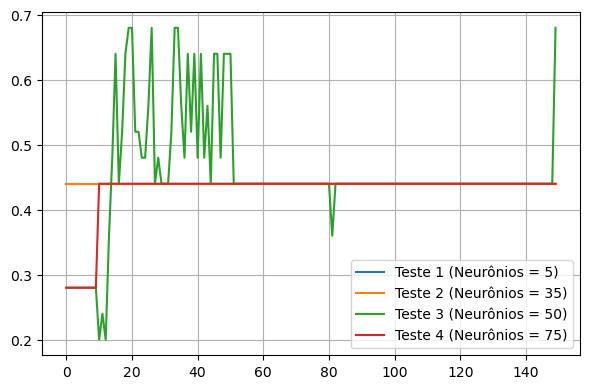

In [8]:
plot_multiple_history(multiple_neurons_history, nneurons)

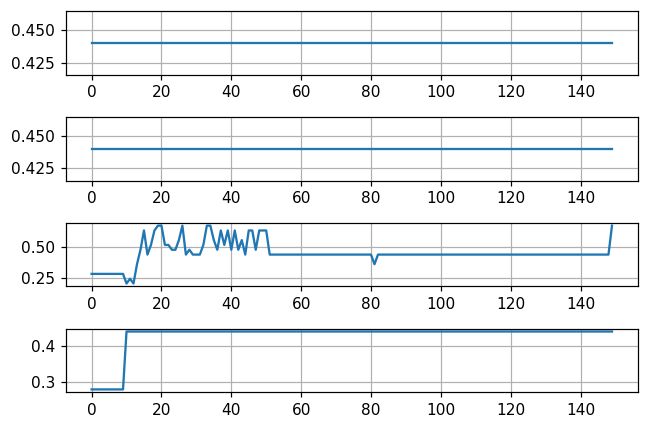

In [9]:
fig, axs = plt.subplots(
    ncols=1, nrows=len(multiple_neurons_history), dpi=110
)

for history, ax in zip(multiple_neurons_history, axs):
    ax.plot(history.epoch, history.history["val_accuracy"])
    ax.grid(True)

plt.tight_layout()

Com base nos resultados apresentados, buscas e mais testes começaram a ser realizados para a identificação da forma de resolver o problema apresentado. Após diversas iterações e pesquisas, foi identificado que o problema está na não normalização dos dados, já que a não realização deste processo causa problemas para o algoritmo de retropropagação que, como visto durante as aulas, para dados não normalizados, tem-se discrepâncias de comportamento do gradiente, o que dificulta o aprendizado e a convergência da rede.

Considerando isto, neste primeiro momento, foi realizado o processo de padronização estatística nos 13 atributos presentes no conjunto de dados. Todo o processo foi realizado com o auxílio da biblioteca `scikit-learn`.

> Optou-se por padronização neste momento para que o processo de testes incrementais pudesse ser realizado. No Teste 1.8, é apresentado uma forma de resolver este problema sem ter de normalizar/padronizar para tratar os problemas causados por gradientes de valores diferentes e sua influência nos passos na superfície de erro.

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Com os dados padronizados, o mesmo processo de treinamento aplicado anteriormente foi utilizado.

In [14]:
multiple_neurons_history_scaled = [
    test1_model_factory(x_train_scaled, y_train, i) for i in nneurons
]

Abaixo é feita a apresentação da acurácia de validação dos testes realizados.

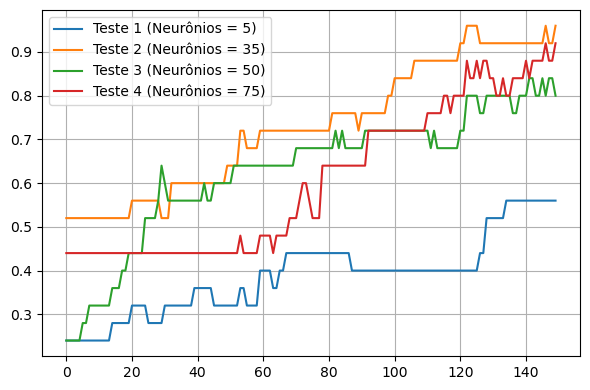

In [12]:
plot_multiple_history(multiple_neurons_history_scaled, nneurons)

Após fazer a mudança, pode-se perceber a influência desta transformação aos dados. Ao verificar o resultado, é possível identificar que o modelo gerado no teste 2, com 35 neurônios na única camada disponível, foi o que apresentou os melhores resultados. Vamos utilizar então este modelo como base para verificar a acurácia geral nos dados de teste.

In [15]:
basemodel = keras.models.Sequential(
    [
        layers.Input(shape=(13,)),
        layers.Dense(35, activation="sigmoid"),
        layers.Dense(3, activation="softmax"),
    ]
)

basemodel.compile(loss="mse", optimizer="sgd", metrics="accuracy")

**Treinando o modelo**

Mesmo com a possível influência da inicialização aleatória dos parâmetros, o modelo foi treinado novamente. Isso torna possível a verificação dos impactos causados pelo modelo de inicialização padrão aplicado pelo `Keras` aos `pesos` e `bias` da rede neural.

In [16]:
history = basemodel.fit(
    x_train_scaled,
    y_train,
    epochs=150,
    verbose=0,
    validation_split=0.2,
)

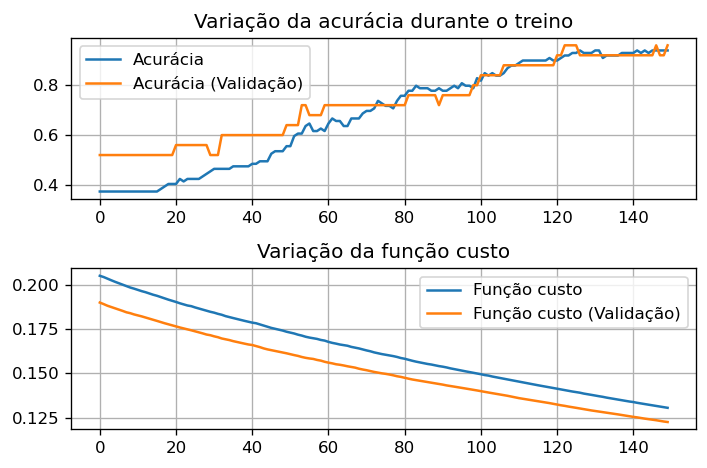

In [18]:
plot_model_fit(history)

Com o modelo gerado e treinado, é feita a verificação de sua generalização através da classificação do conjunto de teste.

In [19]:
basemodel.evaluate(x=x_test_scaled, y=y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.1325 - accuracy: 0.9259


[0.13254427909851074, 0.9259259104728699]

### Teste 1.2 - Taxa de aprendizado

Este teste tem como objetivo, verificar qual é a influência da taxa de aprendizado no modelo definido nos passos anteriores ao considerar o conjunto de dados selecionados para este experimento.

**Funções auxiliares**

In [17]:
def test2_generate_model_with_different_learning_rate(
    x_train_,
    y_train_,
    learning_rate,
    epochs=150,
    validation_split=0.2,
) -> tuple:
    _basemodel = keras.models.Sequential(
        [
            layers.Input(shape=(13,)),
            layers.Dense(35, activation="sigmoid"),
            layers.Dense(3, activation="softmax"),
        ]
    )

    _basemodel.compile(
        loss="mse",
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        metrics="accuracy",
    )

    # returns fit history and fitted model
    return (
        _basemodel.fit(
            x_train_,
            y_train_,
            epochs=epochs,
            verbose=0,
            validation_split=validation_split,
        ),
        _basemodel,
    )

In [18]:
histories_learning_rate_methods = [
    test2_generate_model_with_different_learning_rate(
        x_train_scaled, y_train, 10**-i
    )
    for i in range(1, 5)
]

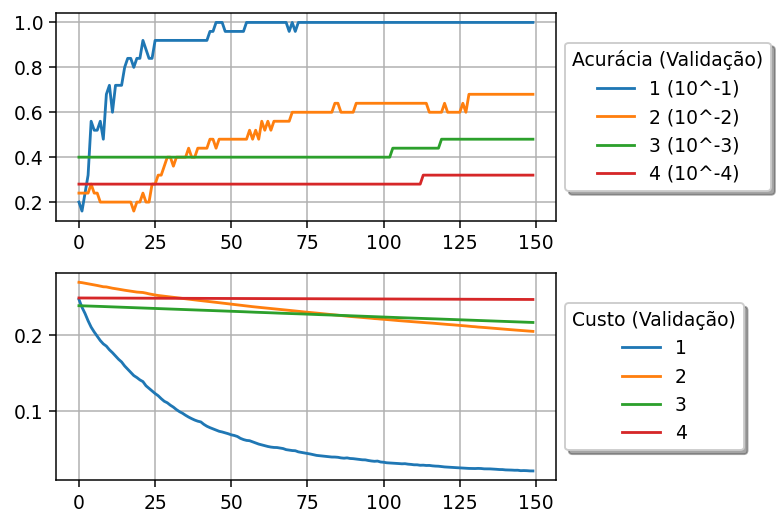

In [19]:
plot_history_curves_by_label(
    histories_learning_rate_methods,
    "10^-{idx}",
    fnc_label=lambda x: x + 1,
)

**Avaliando o resultado com os dados de teste**

Nesta avaliação, o mesmo modelo gerado para a realização das figuras acima são aplicados. O objeto desses foi mantido em memória para evitar  novos processos de treinamento, o que foi visto nos testes anteriores.


In [20]:
for idx in range(len(histories_learning_rate_methods)):
    model = histories_learning_rate_methods[idx][1]
    res = model.evaluate(x_test_scaled, y_test, verbose=0)

    print(
        f"Modelo (Lr = 10 ^ -{idx + 1}) -> Loss({res[0]}) | Accuracy({res[1]})"
    )

Modelo (Lr = 10 ^ -1) -> Loss(0.0358128547668457) | Accuracy(0.9444444179534912)
Modelo (Lr = 10 ^ -2) -> Loss(0.20898552238941193) | Accuracy(0.6481481194496155)
Modelo (Lr = 10 ^ -3) -> Loss(0.19733895361423492) | Accuracy(0.5740740895271301)
Modelo (Lr = 10 ^ -4) -> Loss(0.2231321632862091) | Accuracy(0.46296295523643494)


### Teste 1.3 - Funções de ativação

Neste teste, são realizados testes com as funções de ativação `ReLu`, `Tangente Hiperbólica` e `Sigmóide`. O objetivo é avaliar o comportamento destas três funções de ativação no modelo definido nos passos anteriores.

**Função auxiliar**

In [21]:
def test3_generate_model_with_different_activation_function_in_hidden_layers(
    x_train_,
    y_train_,
    activation_function,
    learning_rate=10**-2,
    epochs=150,
    validation_split=0.2,
) -> tuple:

    _basemodel = keras.models.Sequential(
        [
            layers.Input(shape=(13,)),
            layers.Dense(35, activation=activation_function),
            layers.Dense(3, activation="softmax"),
        ]
    )

    _basemodel.compile(
        loss="mse",
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        metrics="accuracy",
    )

    # returns fit history and fitted model
    return (
        _basemodel.fit(
            x_train_,
            y_train_,
            epochs=epochs,
            verbose=0,
            validation_split=validation_split,
        ),
        _basemodel,
    )

In [22]:
activation_functions = ["sigmoid", "tanh", "relu"]

histories_af_methods = [
    test3_generate_model_with_different_activation_function_in_hidden_layers(
        x_train_scaled, y_train, af
    )
    for af in activation_functions
]

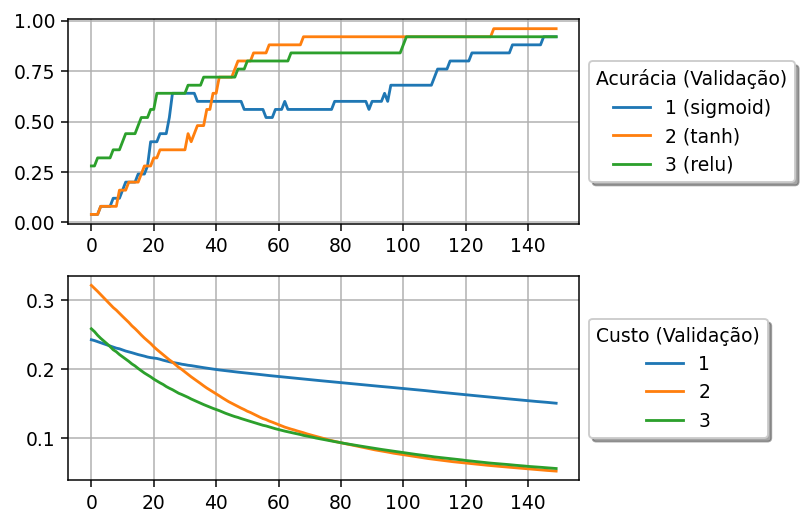

In [23]:
plot_history_curves_by_label(
    histories_af_methods,
    "{idx}",
    fnc_label=lambda i: activation_functions[i],
)

### Teste 1.4 - Momentum

Neste teste foi realizada a verificação do impacto causado pelo `Termo de momentum` no processo de treinamento.

> Vale citar que o `Termo de Momentum` foi aplicado considerando a taxa de aprendizado padrão do Keras (0.01)


**Função auxiliar**

In [27]:
def test4_generate_model_with_different_momentum_in_sgd(
    x_train_, y_train_, momentum, epochs=150, validation_split=0.2
) -> tuple:

    _basemodel = keras.models.Sequential(
        [
            layers.Input(shape=(13,)),
            layers.Dense(35, activation="sigmoid"),
            layers.Dense(3, activation="softmax"),
        ]
    )

    _basemodel.compile(
        loss="mse",
        optimizer=keras.optimizers.SGD(momentum=momentum),
        metrics="accuracy",
    )

    # returns fit history and fitted model
    return (
        _basemodel.fit(
            x_train_,
            y_train_,
            epochs=epochs,
            verbose=0,
            validation_split=validation_split,
        ),
        _basemodel,
    )

In [28]:
momentum_factors = [0.01, 0.1, 0.2, 0.5, 1]

histories_mf_methods = [
    test4_generate_model_with_different_momentum_in_sgd(
        x_train_scaled, y_train, mf
    )
    for mf in momentum_factors
]

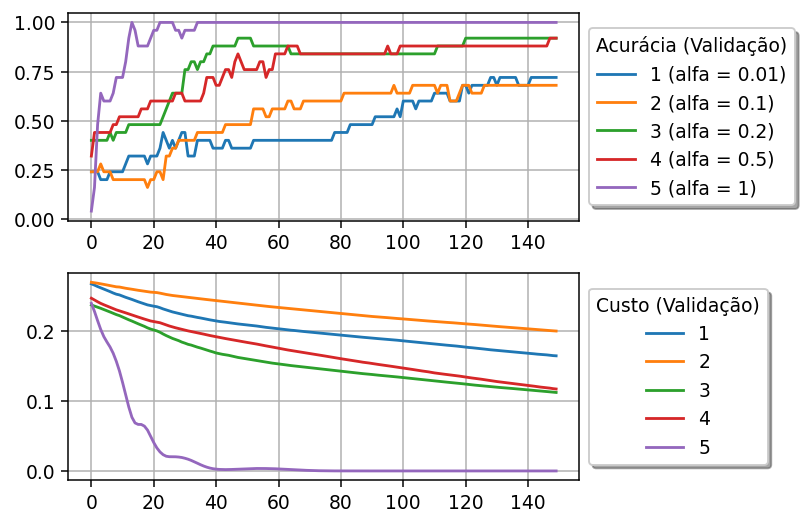

In [29]:
plot_history_curves_by_label(
    histories_mf_methods,
    "alfa = {idx}",
    fnc_label=lambda i: momentum_factors[i],
)

### Teste 1.5 - Regularização dos pesos (L2)

> "Quanto não linear eu deixo minha função de ativação" - Quiles, 2020


In [30]:
def test5_generate_model_with_regularization_l2(
    x_train_, y_train_, rl2, epochs=150, validation_split=0.2
) -> tuple:

    _basemodel = keras.models.Sequential(
        [
            layers.Input(shape=(13,)),
            # "kernel_regularizer" é usado para aplicar a regularização na matriz de pesos (Como vimos em sala de aula)
            # (https://keras.io/api/layers/core_layers/dense/)
            layers.Dense(
                35,
                activation="sigmoid",
                kernel_regularizer=keras.regularizers.l2(rl2),
            ),
            layers.Dense(3, activation="softmax"),
        ]
    )

    _basemodel.compile(
        loss="mse",
        optimizer=keras.optimizers.SGD(),
        metrics="accuracy",
    )

    return (
        _basemodel.fit(
            x_train_,
            y_train_,
            epochs=epochs,
            verbose=0,
            validation_split=validation_split,
        ),
        _basemodel,
    )

In [31]:
# 0.01 é o valor padrão para a regularização L2 no Keras (https://keras.io/api/layers/regularizers/)
l2_rate = [0.01, 0.05, 0.1, 0.5, 1]

histories_l2_rate = [
    test5_generate_model_with_regularization_l2(
        x_train_scaled, y_train, rl2
    )
    for rl2 in l2_rate
]

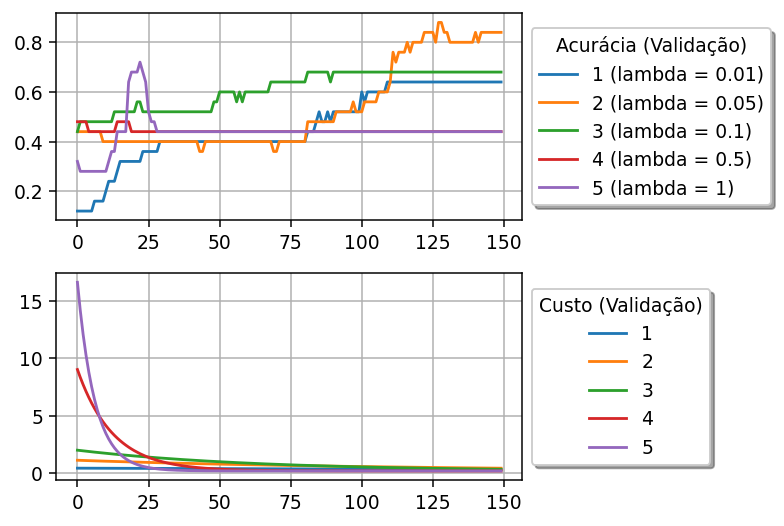

In [32]:
plot_history_curves_by_label(
    histories_l2_rate,
    "lambda = {idx}",
    fnc_label=lambda i: l2_rate[i],
)

### Teste 1.6 - Otimizando hiperparâmetros com Grid Search

Até este teste, todos os hiperparâmetros da rede foram sendo definidos para a realização de testes e o entendimento do impacto que cada um desses tem sobre o processo de aprendizagem e o desempenho geral da rede. Neste teste será feita a aplicação de um algoritmo básico para a identificação de hiperparâmetros, o Grid Search. Para a aplicação, será utilizado o `Keras` junto ao `scikit-learn` através da classe `wrapper` `tf.keras.wrappers.scikit_learn.KerasClassifier`.


In [24]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

Primeiro é feita a criação do modelo. Aqui, será feito o uso do modelo base do Teste 1.1, porém, com mudanças na função de ativação da camada oculta empregada. 

**Função auxiliar**

In [25]:
def test6_model_factory_fnc(optimizer, activation, rl2):
    """Factory para criação do modelo utilizado no teste 6"""
    _model = keras.models.Sequential(
        [
            layers.Input(shape=(13,)),
            layers.Dense(
                35,
                activation=activation,
                kernel_regularizer=keras.regularizers.l2(rl2),
            ),
            layers.Dense(3, activation="softmax"),
        ]
    )

    _model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics="accuracy",
    )

    return _model

Aplicação da busca com GridSearch

In [26]:
skmodel = KerasClassifier(
    build_fn=test6_model_factory_fnc, epochs=150, verbose=0
)

/tmp/ipykernel_133613/3998258160.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  skmodel = KerasClassifier(


> Detalhes da influência dos otimizadores são levantados no Teste 1.8

In [27]:
hyperparameters_grid = {
    "epochs": [20, 50, 70, 150],
    "optimizer": ["sgd", "adam", "rmsprop"],
    "activation": ["relu", "tanh", "sigmoid"],
    "rl2": [0.001, 0.01, 0.05, 0.1],
}

# aplicando o GridSearch
gscv = GridSearchCV(
    estimator=skmodel, param_grid=hyperparameters_grid
)

skmodel_fitted = gscv.fit(x_train_scaled, y_train)

Visualizando os hiperparâmetros definido pela busca

In [28]:
print(
    f"Acurácia alcançada com o modelo selecionado: {skmodel_fitted.best_score_}"
)
print(skmodel_fitted.best_params_)

Acurácia alcançada com o modelo selecionado: 1.0
{'activation': 'relu', 'epochs': 70, 'optimizer': 'adam', 'rl2': 0.001}


Avaliando o modelo resultante

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_testnu, skmodel_fitted.predict(x_test_scaled))

### Teste 1.7 - Função de custo

No Teste 1.6, para a realização da busca, o modelo utilizado como base, utilizava da função de custo `Cross-Entropy`. Como forma de avaliar a influência deste parâmetro de maneira mais clara e direta fez-se a criação deste teste. Neste, será realizado o processo de treinamento e avaliação do modelo com os melhores resultados do Teste 1.1, alterando neste, a função de custo.

Isto é feito para avaliar a possibilidade de evitar as baixas nos gradientes ([Nielsen, 2015](http://neuralnetworksanddeeplearning.com/chap3.html)), que podem ser causadas ao utilizar a função `MSE`.

In [ ]:
model_crossentropy = keras.models.Sequential(
    [
        layers.Input(shape=(13,)),
        layers.Dense(35, activation="sigmoid"),
        layers.Dense(3, activation="softmax"),
    ]
)
model_crossentropy.compile(
    loss="categorical_crossentropy",
    optimizer="sgd",
    metrics="accuracy",
)
crossentropy_history = model_crossentropy.fit(
    x_train_scaled,
    y_train,
    epochs=150,
    verbose=0,
    validation_split=0.2,
)

In [ ]:
plot_model_fit(crossentropy_history)

Avaliando o resultado gerado

In [ ]:
model_crossentropy.evaluate(x_test_scaled, y_test)

    <br>
    <img src="https://i.imgur.com/pD0hWu5.gif" align="right" width="320" />

### Teste 1.8 - Otimizadores

No Teste 1.1, foi realizado o processo de padronização dos dados. Neste teste, busca-se realizar a aplicação de otimizações que em sua estrutura já apresentam mecanismos que tentam tratar e minimizar a influência da discrepância entre os gradientes. Assim, será feita a aplicação dos otimizadores `RMSProp` e `Adam`, vistos em aula. O objetivo é verificar o comportamento da rede, apenas com a mudança deste parâmetro.

Para a realização dos testes, será feito o uso do modelo que apresentou os melhores resultados no Teste 1.1.

> O conjunto de dados utilizado neste teste não está padronizado, como o feito no Teste 1.1


**RMSprop**

In [ ]:
# Treinando o modelo (Modelo com os melhores resultados do Teste 1.1)
model_rmsprop = keras.models.Sequential(
    [
        layers.Input(shape=(13,)),
        layers.Dense(35, activation="sigmoid"),
        layers.Dense(3, activation="softmax"),
    ]
)
model_rmsprop.compile(
    loss="mse",
    # Considerando o RMSprop com os parâmetros padrão
    optimizer=keras.optimizers.RMSprop(),
    metrics="accuracy",
)
rmsprop_history = model_rmsprop.fit(
    x_train, y_train, epochs=150, verbose=0, validation_split=0.2
)

# Visualizando o processo de aprendizado
plot_model_fit(rmsprop_history)

**Adam**

In [ ]:
# Treinamento
model_adam = keras.models.Sequential(
    [
        layers.Input(shape=(13,)),
        layers.Dense(35, activation="sigmoid"),
        layers.Dense(3, activation="softmax"),
    ]
)
model_adam.compile(
    loss="mse",
    # Durante os testes foi notado a melhora com a diminuição da taxa de aprendizado
    optimizer=keras.optimizers.Adam(learning_rate=0.007),
    metrics="accuracy",
)
adam_history = model_adam.fit(
    x_train, y_train, epochs=150, verbose=0, validation_split=0.2
)

# Visualização
plot_model_fit(adam_history)

<hr>

## Experimento 2

Até este experimento, todos os testes que foram realizados focaram na avaliação dos hiperparâmetros e sua influência em um modelo simples, considerando um pequeno conjunto de dados. Para realizar mais aplicações do modelo MLP e fixar os conceitos vistos, este segundo experimento será realizado.

Para este experimento, tem-se como objetivo, adicionais mais camadas ocultas e verificar o comportamento da rede.

### Conjunto de dados

Para a realização deste experimento, será utilizado o conjunto de dados [MNIST Database of handwritten digits](http://yann.lecun.com/exdb/mnist/), disponibilizado e utilizado por Yann Lecun durante o processo de desenvolvimento das Redes Neurais Convolucionais. O conjunto de dados é constituído de 70 mil imagens (aqui sendo aplicado 60 mil para treino e 10 mil para teste) de digitos manuais de números de 0 a 10.

> O conjunto de dados será recuperado do [OpenML](https://www.openml.org/) com o auxílio da biblioteca `scikit-learn`. 

Abaixo os dados são carregados e alguns exemplos são apresentados.

In [ ]:
from sklearn.datasets import fetch_openml

mnistdatax, mnistdatay = fetch_openml(
    "mnist_784", version=1, return_X_y=True
)

**Amostras do conjunto de dados MNIST**

In [ ]:
_, axs = plt.subplots(nrows=1, ncols=9, dpi=200)
for idx in range(0, 9):
    axs[idx].set_axis_off()
    axs[idx].imshow(
        mnistdatax[idx].reshape((28, 28)),
        cmap=plt.cm.gray_r,
        interpolation="nearest",
    )

**Formatação e tratamento nos dados**

In [ ]:
# Organizando os dados de forma a tornar a reprodução dos resultados
from sklearn.utils import check_random_state

# Esta etapa de pré-processamento foi retirada da documentação do scikit-learn
# (https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html)
random_state = check_random_state(random_seed)
permutation = random_state.permutation(mnistdatax.shape[0])
mnistdatax = mnistdatax[permutation]
mnistdatay = mnistdatay[permutation]

Dividindo os dados em treino e teste

In [ ]:
(
    x_mnisttrain,
    x_mnisttest,
    y_mnisttrain,
    y_mnisttest,
) = train_test_split(
    mnistdatax, mnistdatay, test_size=10000, random_state=random_seed
)

y_mnisttrain = y_mnisttrain.astype(int)
y_mnisttest = y_mnisttest.astype(int)

In [ ]:
# Escalando valores
x_mnisttrain_scaled = x_mnisttrain / 255.0
x_mnisttest_scaled = x_mnisttest / 255.0

### Teste 2.1 - Quantidade de camadas

Neste teste, tem-se por objetivo verificar a influência da quantidade de camadas frente ao conjunto de dados que está sendo trabalhado.


**Função auxiliar**

In [ ]:
def test_21_compile_and_fit_model_with_default_parameters(
    model, x_data_, y_data_, epochs=100, validation_split=0.3
):
    """Função auxiliar para compilar um modelo keras.Sequential seguindo
    as definições padrão utilizadas no teste 2.1

    Args:
        model (keras.Sequential): Modelo a ser treinado
        x_data_ (np.ndarray): Array multidimensional com os dados do experimento 2
        y_data_ (np.ndarray): Array 1D com as respostas esperadas para cada amostra no conjunto x_data_
        epochs (int): Quantidade de épocas utilizadas no treinamento
        validation_split (float): Fração dos dados que deve ser considerada para a validação durante o treinamento
    Returns:
        keras.history: Histórico de treinamento
    """
    model.compile(
        # Mesma função de perda crossentropy, apenas não exige o formato one-hot-encoded como entrada
        # https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(),
        metrics="accuracy",
    )

    return model.fit(
        x_data_,
        y_data_,
        epochs=epochs,
        validation_split=validation_split,
    )

**Uma camada oculta**

Para iniciar, na primeira iteração com o conjunto de dados, será considerado uma rede com apenas uma camada oculta com esta contendo 5 neurônios.


In [ ]:
modelmnist_test211 = keras.Sequential(
    [
        keras.layers.Input(shape=(28 * 28,)),
        keras.layers.Dense(10, activation="relu"),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

modelmnist_test211_history = (
    test_21_compile_and_fit_model_with_default_parameters(
        modelmnist_test211, x_mnisttrain_scaled, y_mnisttrain
    )
)
modelmnist_test211.evaluate(x_mnisttest_scaled, y_mnisttest)

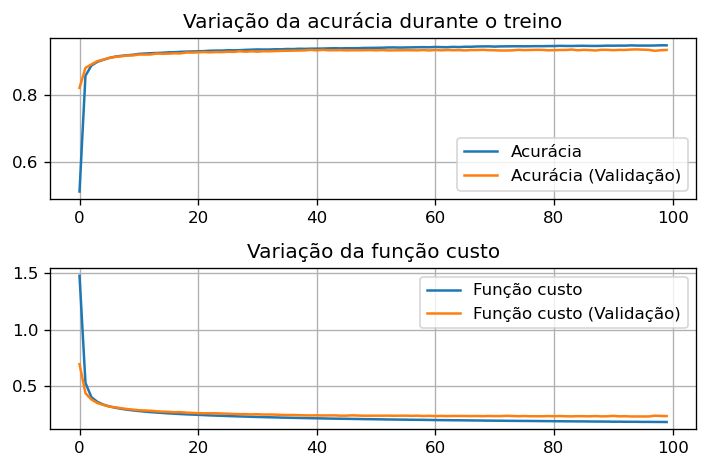

In [48]:
plot_model_fit(modelmnist_test211_history)

**Adicionando mais neurônios**

Como forma de avaliação, inicialmente foi feita a adição de mais neurônios na camada oculta.


In [49]:
modelmnist_test212 = keras.Sequential(
    [
        keras.layers.Input(shape=(28 * 28,)),
        keras.layers.Dense(30, activation="relu"),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

modelmnist_test212_history = (
    test_21_compile_and_fit_model_with_default_parameters(
        modelmnist_test212, x_mnisttrain_scaled, y_mnisttrain
    )
)
modelmnist_test212.evaluate(x_mnisttest_scaled, y_mnisttest)

Epoch 1/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.8392 - accuracy: 0.7872 - val_loss: 0.4639 - val_accuracy: 0.8778
Epoch 2/100
1313/1313 [==============================] - 3s 2ms/step - loss: 0.4000 - accuracy: 0.8903 - val_loss: 0.3629 - val_accuracy: 0.8994
Epoch 3/100
1313/1313 [==============================] - 3s 2ms/step - loss: 0.3396 - accuracy: 0.9051 - val_loss: 0.3295 - val_accuracy: 0.9068
Epoch 4/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.3108 - accuracy: 0.9128 - val_loss: 0.3061 - val_accuracy: 0.9121
Epoch 5/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.2908 - accuracy: 0.9179 - val_loss: 0.2895 - val_accuracy: 0.9181
Epoch 6/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.2751 - accuracy: 0.9228 - val_loss: 0.2747 - val_accuracy: 0.9223
Epoch 7/100
1313/1313 [==============================] - 3s 2ms/step - loss: 0.2620 - accuracy: 0.9269 - val_loss: 0.2639 - val_ac

[0.14157415926456451, 0.9614999890327454]

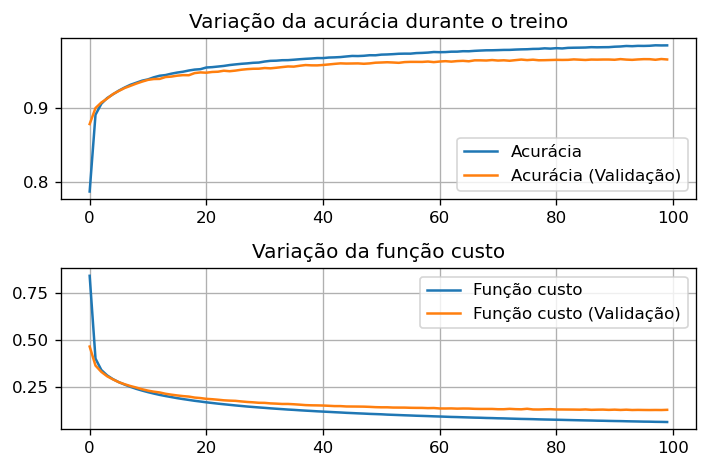

In [50]:
plot_model_fit(modelmnist_test212_history)

**Duas camadas ocultas e Dropout**

Para finalizar este teste, uma segunda camada foi adicionada, junto a esta, foi aplicado a técnica de Dropout para entender seu comportamento. 

> Neste teste será aplicado também a ideia de `Taxa de aprendizado` variável, apresentada nas aulas. Para isto, utilizando do *callback* [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/), é definido que, quando uma determinada métrica (e. g. val_loss) deixar de melhorar com os passos, faz-se a redução da taxa de aprendizado por um certo fator.


In [51]:
modelmnist = keras.Sequential(
    [
        keras.layers.Input(shape=(28 * 28,)),
        keras.layers.Dense(30, activation="relu"),
        # Desativa unidades (Efeito equivalente a regularização L2) -> 9 neurônios sendo retirados
        keras.layers.Dropout(0.3),
        keras.layers.Dense(15, activation="relu"),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

modelmnist.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(),
    metrics="accuracy",
)

# Configurando ReduceLROnPlateau Callback
rlr_on_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=2, min_lr=0.001
)

mnisthistory = modelmnist.fit(
    x_mnisttrain_scaled,
    y_mnisttrain,
    epochs=100,
    validation_split=0.3,
    callbacks=[rlr_on_plateau],
)

modelmnist.evaluate(x_mnisttest_scaled, y_mnisttest)

Epoch 1/100
1313/1313 [==============================] - 3s 3ms/step - loss: 1.2792 - accuracy: 0.5858 - val_loss: 0.5728 - val_accuracy: 0.8491
Epoch 2/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.6651 - accuracy: 0.7925 - val_loss: 0.4041 - val_accuracy: 0.8888
Epoch 3/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.5287 - accuracy: 0.8367 - val_loss: 0.3456 - val_accuracy: 0.9020
Epoch 4/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.4680 - accuracy: 0.8571 - val_loss: 0.3122 - val_accuracy: 0.9100
Epoch 5/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.4330 - accuracy: 0.8698 - val_loss: 0.2893 - val_accuracy: 0.9171
Epoch 6/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.4011 - accuracy: 0.8771 - val_loss: 0.2653 - val_accuracy: 0.9230
Epoch 7/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.3847 - accuracy: 0.8835 - val_loss: 0.2551 - val_ac

[0.1627323180437088, 0.9535999894142151]

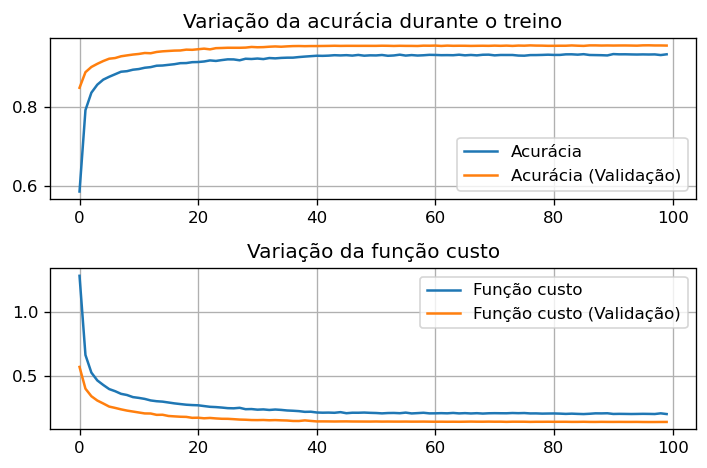

In [52]:
plot_model_fit(mnisthistory)

Além dos resultados apresentados, algumas outras execuções foram feitas de modo a avaliar a quantidade neurônios e camadas frente ao resultado, porém, frente a natureza linear do conjunto de dados ([Mueller, 2012](https://peekaboo-vision.blogspot.com/2012/12/another-look-at-mnist.html)), foi possível perceber que mesmo com uma pequena quantidade de neurônios em uma camada oculta, o resultado apresentado já poderia ser considerado satisfatório. Com a adição de mais neurônios/camadas, poucos ganhos foram identificados.


## Referências

- Michael A. Nielsen, [Neural Networks and Deep Learning](https://books.google.com.br/books?id=STDBswEACAAJ), Determination Press, 2015. Disponível em: http://neuralnetworksanddeeplearning.com/

- Mueller, A., 2012. *Another Look At MNIST*. Peekaboo Vision. Disponível em: <https://peekaboo-vision.blogspot.com/2012/12/another-look-at-mnist.html> [Acessado em 2022-06-11].